In [2]:
import random
from collections import OrderedDict
import os
import matplotlib.pyplot as plt

In [5]:
class EvolvingGraphPageRank():
    
    def __init__(self):
        self.initial_graph = {} # The first constructed graph
        self.new_graph = {} # latest graph after running construct_new_graph()
        self.updated_graph = {} # The updated graph after running construct_new_graph() and update_graph()
        self.image = OrderedDict() # The graph updated based on probing
        self.current_pagerank = {} # PageRank latest graph after running construct_new_graph()
        self.updated_pagerank = {} # PageRank of the updated graph after running construct_new_graph() and update_graph()
        self.num_changes = 0
        self.probe_pagerank = {}
        self.updated_pagerank = {}
        self.probenode = 0
        self.probeneighbours = []
        self.probe_changes = 0
        self.L_inf = OrderedDict()
        self.L1 = OrderedDict()
        self.priority = OrderedDict()

        
    def construct_first_graph(self, filepath):
        with open(filepath) as file:
            df = file.readlines()[4:]
        for line in df:
            f, t = line.split()
            f, t = int(f), int(t) 
            if f not in self.initial_graph:
                self.initial_graph[f] = []
                self.updated_graph[f] = []
                self.image[f] = []
            self.initial_graph[f].append(t)
            self.updated_graph[f].append(t)        
            self.image[f].append(t)      
        self.probe_pagerank = self.PowerIteration(0.15, self.initial_graph)

    def construct_new_graph(self, filepath):
        with open(filepath) as file:
            df = file.readlines()[4:]
        for line in df:
            f, t = line.split()
            f, t = int(f), int(t) 
            if f not in self.new_graph:
                self.new_graph[f] = []
            self.new_graph[f].append(t)
        
        
    def update_image(self):
        
        if self.probenode in self.updated_graph:
            if sorted(self.probeneighbours) == sorted(self.updated_graph[self.probenode]):
                pass
            else:
                for i in self.probeneighbours:
                    if i not in self.updated_graph[self.probenode]:
                        self.image[self.probenode].remove(i)
                        self.probe_changes+=1
                
                for i in self.updated_graph[self.probenode]:
                    if i not in self.probeneighbours:
                        if i not in self.image:
                            self.image[i] = []
                        self.image[self.probenode].append(i)
                        self.probe_changes+=1
                        
        else:
            for i in list(self.image.keys()):
                if self.probenode in self.image[i]:
                    self.image[i].remove(self.probenode)
                    self.probe_changes+=1
            self.image.pop(self.probenode)
            
        self.probe_pagerank = self.PowerIteration(0.15, self.image)
        self.updated_pagerank = self.PowerIteration(0.15, self.updated_graph)
        
        
        
        
    def update_graph(self, method = 'Random'):
        for node in self.new_graph: 
            if node in self.updated_graph:
                if sorted(self.new_graph[node]) == sorted(self.updated_graph[node]): # checking if neighbours matches for nodes in both new and updated graphs
                    pass
                else: 
                    for i in self.new_graph[node]:                     # adding neighbours
                        if i not in self.updated_graph[node]:
                            if i not in self.updated_graph:
                                self.updated_graph[i] = []
                            self.updated_graph[node].append(i)
                            if method == 'Random':
                                self.random_probing()
                                self.update_image()

                            elif method == 'RoundRobin':
                                self.roundrobin_probing()
                                self.update_image()

                            elif method == 'Proportional':
                                self.proportional_probing()
                                self.update_image()

                            elif method == 'Priority':
                                self.priority_probing()
                                self.update_image()
                            self.metrics()
                            self.num_changes += 1

                    temp = self.updated_graph[node].copy()
                    for i in temp:                                    # removing neighbours
                        if i not in self.new_graph[node]:
                            self.updated_graph[node].remove(i)
                            
                            if method == 'Random':
                                self.random_probing()
                                self.update_image()

                            elif method == 'RoundRobin':
                                self.roundrobin_probing()
                                self.update_image()

                            elif method == 'Proportional':
                                self.proportional_probing()
                                self.update_image()

                            elif method == 'Priority':
                                self.priority_probing()
                                self.update_image()
                            self.metrics()
                            self.num_changes += 1
                    
            elif node not in self.updated_graph:
                
                temp = self.new_graph[node].copy()
                self.updated_graph[node] = []
                for i in temp:
                    if i not in self.updated_graph:
                        self.updated_graph[i] = []
                    self.updated_graph[node].append(i)
                    if method == 'Random':
                        self.random_probing()
                        self.update_image()

                    elif method == 'RoundRobin':
                        self.roundrobin_probing()
                        self.update_image()

                    elif method == 'Proportional':
                        self.proportional_probing()
                        self.update_image()

                    elif method == 'Priority':
                        self.priority_probing()
                        self.update_image()
                    self.metrics()
                    self.num_changes += 1
                    
                    
                    
        for i in list(self.updated_graph.keys()): # removing nodes not in new graph
            if i not in self.new_graph:
                self.updated_graph.pop(i) # node removed
                
                
        return self.L_inf, self.L1
            
    
    def PowerIteration(self, alpha, graph):
        pi_prev = {node: 1 / len(graph) for node in graph}
        pi_current = {node: 0 for node in graph}
        abs_diff = max([abs(pi_prev[node] - pi_current[node]) for node in graph])
        while abs_diff >= 1e-9:
            for node, neighbors in graph.items():
                if len(neighbors) > 0:
                    for neighbor_node in neighbors:
                        if neighbor_node in graph:
                            pi_current[neighbor_node] += pi_prev[node] / len(neighbors)
            pi_current = {node: (1 - alpha) * pi_current[node] + alpha / len(graph) for node in graph}
            abs_diff = max([abs(pi_prev[node] - pi_current[node]) for node in graph])
            pi_prev = pi_current
            pi_current = {node: 0 for node in graph}
        for node in pi_prev:
            pi_prev[node] = pi_prev[node] / 7716
        return pi_prev
    

    
    
    
    def random_probing(self):
        self.probenode = random.choice(list(self.image.keys()))
        self.probeneighbours = self.image[self.probenode]
        
        
        
    def roundrobin_probing(self):
        if self.probe_changes == 0:
            self.probenode = list(self.image.keys())[0]
        else:
            if self.probenode == list(self.image.keys())[-1]:
                self.probenode = list(self.image.keys())[0]
            else:
                self.probenode = list(self.image.keys())[list(self.image.keys()).index(self.probenode) + 1]
        
        
    def proportional_probing(self):
        pagerank_weights = {}
        sum_ = sum([self.probe_pagerank[i] for i in self.probe_pagerank])
        
        for node in self.probe_pagerank:
            pagerank_weights[node] = self.probe_pagerank[node] / sum_
            
        self.probenode = random.choices(list(self.image), weights = pagerank_weights)[0]
        self.probeneighbours = self.image[self.probenode]
        
        
    def priority_probing(self):
        for node in self.image.keys():
            if node not in self.priority:
                self.priority[node] = 0
                
        max_priority = max([self.priority[i] for i in self.priority])
        max_indices = [i for i, x in enumerate(list(self.priority.values())) if x == max_priority]
        if len(max_indices) > 1:
            random_index = random.choice(max_indices)
            self.probenode = list(self.image.keys())[random_index]
        elif len(max_indices) == 1:
            self.probenode = list(self.image.keys())[max_indices[0]]
        
        self.probeneighbours = self.image[self.probenode]
        
        self.priority[self.probenode] = 0
        
        for node in self.priority:
            if node != self.probenode:
                self.priority[node] += self.probe_pagerank[node]        

        
    def metrics(self):
        
        if self.probenode not in self.L_inf:
            self.L_inf[self.probenode] = 0
            
        self.L_inf[self.probenode] = max([abs(self.probe_pagerank[node] - self.updated_pagerank[node]) for node in self.image if node in self.updated_graph]) 
        
        if self.probenode not in self.L1:
            self.L1[self.probenode] = 0
        
        self.L1[self.probenode] = sum([abs(self.probe_pagerank[node] - self.updated_pagerank[node]) for node in self.image if node in self.updated_graph]) 
        

In [6]:
priorityprobinggraph = EvolvingGraphPageRank()
priorityprobinggraph.construct_first_graph("as-733/as19971108.txt")
directory = 'as-733'
c = 0

for filename in os.listdir(directory):
    c += 1
    print(".", end="")
    if c != 1:
        priorityprobinggraph.construct_new_graph(f"{directory}/{filename}")
        priorityprobinggraph.update_graph(method = 'Priority')

        

........................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

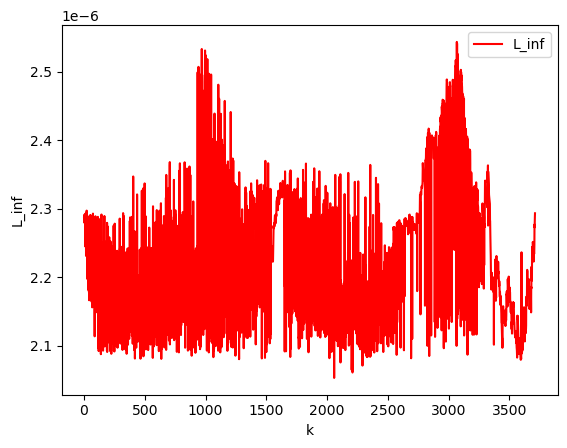

In [9]:
k = 0
k_values = []
L_inf_values = []


for _, L_inf in priorityprobinggraph.L_inf.items():
    k += 1
    k_values.append(k)
    L_inf_values.append(L_inf)
    print(".", end="")



plt.plot(k_values, L_inf_values, color='red', label='L_inf')
plt.xlabel('k')
plt.ylabel('L_inf')
plt.legend()
plt.show()
        

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

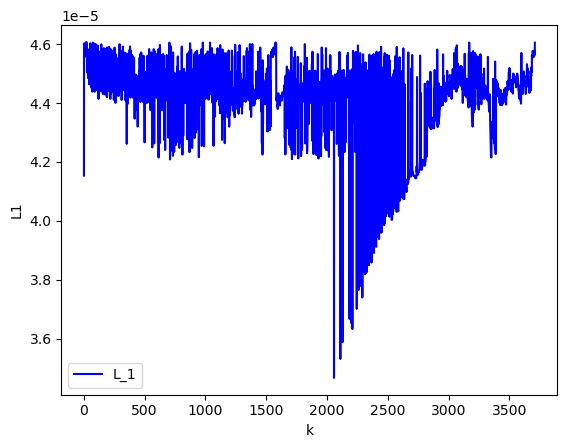

In [11]:
L_1_values = []


for _, L_1 in priorityprobinggraph.L1.items():
    L_1_values.append(L_1)
    print(".", end="")

plt.plot(k_values, L_1_values, color='blue', label='L_1')
plt.xlabel('k')
plt.ylabel('L1')
plt.legend()
plt.show()

In [1]:
# randomprobinggraph = EvolvingGraphPageRank()
# randomprobinggraph.construct_first_graph("as-733/as19971108.txt")
# directory = 'as-733'
# c = 0

# for filename in os.listdir(directory):
#     c += 1
#     print(".", end="")
#     if c != 1:
#         randomprobinggraph.construct_new_graph(f"{directory}/{filename}")
#         randomprobinggraph.update_graph(method = 'Random')
# k = 0
# k_values = []
# L_inf_values = []
# L_1_values = []

# for _, L_inf in randomprobinggraph.L_inf.items():
#     k += 1
#     k_values.append(k)
#     L_inf_values.append(L_inf)
#     print(".", end="")
    
# for _, L_1 in priorityprobinggraph.L_1.items():
#     L_1_values.append(L_1)
#     print(".", end="")

# plt.scatter(k_values, L_inf_values, color='red', label='L_inf')
# plt.scatter(k_values, L_1_values, color='blue', label='L_1')
# plt.xlabel('k')
# plt.ylabel('L_inf and L_1')
# plt.legend()
# plt.show()
        
        

In [2]:
# roundrobinprobinggraph = EvolvingGraphPageRank()
# roundrobinprobinggraph.construct_first_graph("as-733/as19971108.txt")
# directory = 'as-733'
# c = 0

# for filename in os.listdir(directory):
#     c += 1
#     print(c, filename)
#     if c != 1:
#         roundrobinprobinggraph.construct_new_graph(f"{directory}/{filename}")
#         roundrobinprobinggraph.update_graph(method = 'RoundRobin')
        

# k = 0
# k_values = []
# L_inf_values = []
# L_1_values = []

# for _, L_inf in roundrobinprobinggraph.L_inf.items():
#     k += 1
#     k_values.append(k)
#     roundrobin_Linf.append(L_inf)
#     print(k, _, L_inf)

# for _, L_1 in roundrobinprobinggraph.L_1.items():
#     L_1_values.append(L_1)
#     print(".", end="")

# plt.scatter(k_values, L_inf_values, color='red', label='L_inf')
# plt.scatter(k_values, L_1_values, color='blue', label='L_1')
# plt.xlabel('k')
# plt.ylabel('L_inf and L_1')
# plt.legend()
# plt.show() 

In [3]:
# proportionalprobinggraph = EvolvingGraphPageRank()
# proportionalprobinggraph.construct_first_graph("as-733/as19971108.txt")
# directory = 'as-733'
# c = 0

# for filename in os.listdir(directory):
#     c += 1
#     print(".", end="")
#     if c != 1:
#         proportionalprobinggraph.construct_new_graph(f"{directory}/{filename}")
#         proportionalprobinggraph.update_graph(method = 'Proportional')
# k = 0
# k_values = []
# L_inf_values = []
# L_1_values = []

# for _, L_inf in proportionalprobinggraph.L_inf.items():
#     k += 1
#     k_values.append(k)
#     L_inf_values.append(L_inf)
#     print(".", end="")
    
# for _, L_1 in proportionalprobinggraph.L_1.items():
#     L_1_values.append(L_1)
#     print(".", end="")

# plt.scatter(k_values, L_inf_values, color='red', label='L_inf')
# plt.scatter(k_values, L_1_values, color='blue', label='L_1')
# plt.xlabel('k')
# plt.ylabel('L_inf and L_1')
# plt.legend()
# plt.show()
        
        

In [12]:
import pandas as pd
d = {"L_1_values": L_1_values, "L_inf_values": L_inf_values}
df = pd.DataFrame(data = d)

In [13]:
#df.to_csv("AS_Priority.csv")

In [1]:
import pandas as pd
df = pd.read_csv("AS_Priority.csv")

In [3]:
df

,Unnamed: 0,L_1_values,L_inf_values
0,0,0.000042,0.000002
1,1,0.000046,0.000002
2,2,0.000046,0.000002
3,3,0.000046,0.000002
4,4,0.000046,0.000002
...,...,...,...
3705,3705,0.000046,0.000002
3706,3706,0.000046,0.000002
3707,3707,0.000046,0.000002
3708,3708,0.000046,0.000002


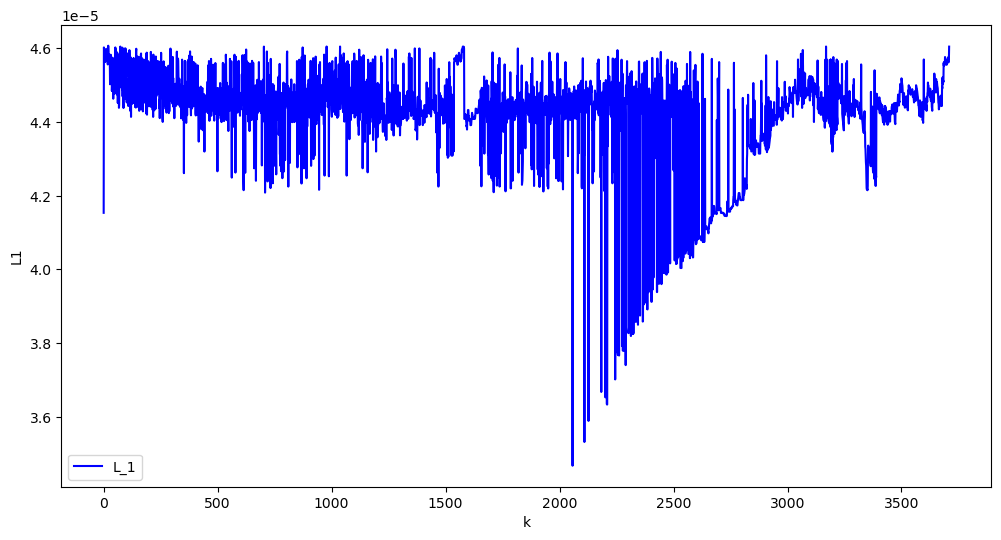

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df["Unnamed: 0"], df["L_1_values"], color='blue', label='L_1')
plt.xlabel('k')
plt.ylabel('L1')
plt.legend()
plt.show()

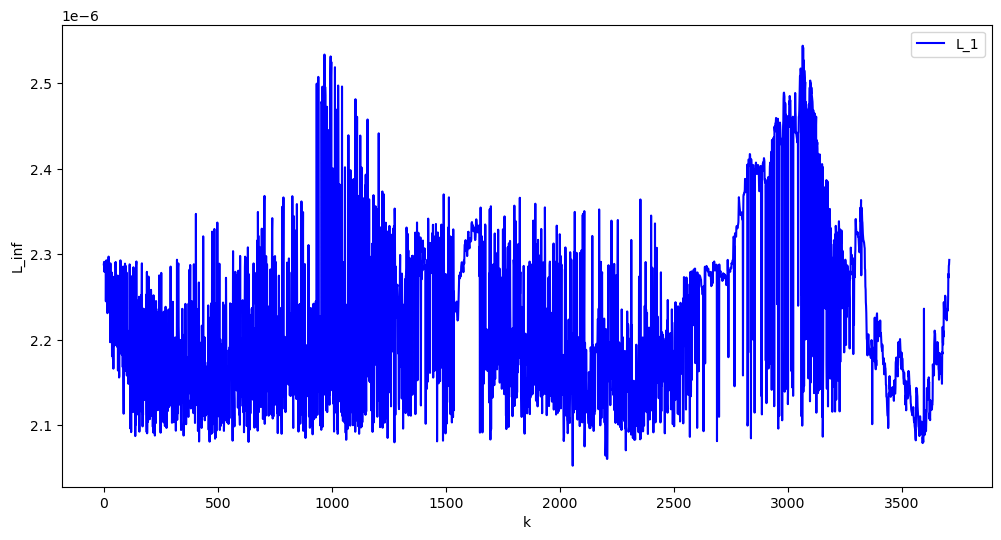

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df["Unnamed: 0"], df["L_inf_values"], color='blue', label='L_1')
plt.xlabel('k')
plt.ylabel('L_inf')
plt.legend()
plt.show()